In [3]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pandas as pd
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib as mpl
mpl.rc("font", family='Droid Sans Fallback', weight="bold")
from datetime import datetime
import os

In [4]:
# 涨停板为10%，剔除涨停板为5%，20%，30%的标的
# 做法：选出当日收益率小于或等于11%的股票（允许浮动）
event_ret = ((ff.rets_all<=0.11) & (ff.rets_all>=0.09)).replace({True:1,False:np.nan})
# 收盘涨停：
event_close = ((ff.read('close')-ff.read('up_limit'))==0).replace({True:1,False:np.nan})

up_data = event_ret*ff.read('up')*event_close

In [2]:
import psutil
import os

print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3) )

info = psutil.virtual_memory()
print(u'电脑总内存：%.4f GB' % (info.total / 1024 ** 3) )
print(u'当前使用的总内存占比：',info.percent)
print(u'cpu个数：',psutil.cpu_count())

当前进程的内存使用：0.0629 GB
电脑总内存：1007.4503 GB
当前使用的总内存占比： 76.1
cpu个数： 256


# 是否为一字涨停

In [5]:
codes = up_data.index.tolist()
index_lst = up_data.columns
# 是否为一字涨停
# 一字涨停表示在涨停状态下，该股票的价格没有发生过任何交易，一直保持在涨停价的水平上，直到当日的交易结束
def get_always_up(code):
    result = pd.Series(np.nan,index = index_lst,name = code)
    dates_1 = up_data.loc[code,:].dropna().index
    if len(dates_1) == 0:
        pass
    else:
        datas = ff.read_min(code).loc[:,['close','high_limit']]
        for date1 in dates_1:
            try:
                date2 = str(int(date1)+1)
                date1_re = date1[:4] + '-' + date1[4:6] + '-' + date1[6:]
                date2_re = date2[:4] + '-' + date2[4:6] + '-' + date2[6:]
                daily_data = datas.loc[date1_re:date2_re] 
                op_values = (daily_data['close']-daily_data['high_limit']).values
                i = False
                j = True
                for value in op_values:
                    if value == 0:
                       i = True
                    elif i:
                        j = False
                if i and j:
                    result[date1] = 1
            except IndexError as e:
                pass
    return result

In [6]:
with Pool(36) as p:
    res_lst = list(tqdm(p.imap(get_always_up,codes),total=len(codes)))
always_up_event = pd.concat(res_lst,axis = 1)

100%|████████████████████████████████████████████████████████████| 5540/5540 [01:26<00:00, 64.28it/s]


# 是否炸板

In [7]:
# 股票炸板即股票打开涨停板，或者打开跌停板
def get_break(code):
    result = pd.Series(np.nan,index = index_lst,name = code)
    dates_1 = up_data.loc[code,:].dropna().index
    if len(dates_1) == 0:
        pass
    else:
        datas = ff.read_min(code).loc[:,['close','high_limit']]
        for date1 in dates_1:
            try:
                date2 = str(int(date1)+1)
                date1_re = date1[:4] + '-' + date1[4:6] + '-' + date1[6:]
                date2_re = date2[:4] + '-' + date2[4:6] + '-' + date2[6:]
                daily_data = datas.loc[date1_re:date2_re] 
                op_values = (daily_data['close']-daily_data['high_limit']).values
                i = False
                j = False
                for value in op_values:
                    if value == 0:
                       i = True
                    elif i:
                        j = True
                if i and j:
                    result[date1] = 1
            except IndexError as e:
                pass
    return result

In [8]:
with Pool(36) as p:
    res_lst = list(tqdm(p.imap(get_break,codes),total=len(codes)))
break_event = pd.concat(res_lst,axis = 1)

100%|███████████████████████████████████████████████████████████| 5540/5540 [00:19<00:00, 291.16it/s]


# 涨停时间

In [9]:
def get_time(code):
    result = pd.Series(np.nan,index = index_lst,name = code)
    dates_1 = up_data.loc[code,:].dropna().index
    if len(dates_1) == 0:
        pass
    else:
        datas = ff.read_min(code).loc[:,['close','high_limit']]
        for date1 in dates_1:
            try:
                date2 = str(int(date1)+1)
                date1_re = date1[:4] + '-' + date1[4:6] + '-' + date1[6:]
                date2_re = date2[:4] + '-' + date2[4:6] + '-' + date2[6:]
                daily_data = datas.loc[date1_re:date2_re] 
                op_values = (daily_data['close']-daily_data['high_limit']).values
                i = 0
                for value in op_values:
                    if value == 0:
                       i += 1
                result[date1] = i
            except IndexError as e:
                pass
    return result

In [10]:
with Pool(36) as p:
    res_lst = list(tqdm(p.imap(get_time,codes),total=len(codes)))
up_time = pd.concat(res_lst,axis = 1).sort_index()

100%|███████████████████████████████████████████████████████████| 5540/5540 [00:17<00:00, 312.97it/s]


# 首次涨停时刻的成交量

In [13]:
def get_first_volume(code):
    result = pd.Series(np.nan,index = index_lst,name = code)
    dates_1 = up_data.loc[code,:].dropna().index
    if len(dates_1) == 0:
        pass
    else:
        datas = ff.read_min(code).loc[:,['close','high_limit','volume']]
        for date1 in dates_1:
            try:
                date2 = str(int(date1)+1)
                date1_re = date1[:4] + '-' + date1[4:6] + '-' + date1[6:]
                date2_re = date2[:4] + '-' + date2[4:6] + '-' + date2[6:]
                daily_data = datas.loc[date1_re:date2_re] 
                op_values = (daily_data['close']-daily_data['high_limit']).values
                volume_values = daily_data['volume'].values
                for i in range(len(op_values)):
                    if op_values[i] == 0:
                        result[date1] = volume_values[i]
                        break
            except IndexError as e:
                pass
    return result

In [14]:
with Pool(36) as p:
    res_lst = list(tqdm(p.imap(get_first_volume,codes),total=len(codes)))
first_volume = pd.concat(res_lst,axis = 1).sort_index()

100%|███████████████████████████████████████████████████████████| 5540/5540 [00:18<00:00, 299.67it/s]


# 涨停板上的成交量

In [15]:
def get_up_volume(code):
    result = pd.Series(np.nan,index = index_lst,name = code)
    dates_1 = up_data.loc[code,:].dropna().index
    if len(dates_1) == 0:
        pass
    else:
        datas = ff.read_min(code).loc[:,['close','high_limit','volume']]
        for date1 in dates_1:
            try:
                date2 = str(int(date1)+1)
                date1_re = date1[:4] + '-' + date1[4:6] + '-' + date1[6:]
                date2_re = date2[:4] + '-' + date2[4:6] + '-' + date2[6:]
                daily_data = datas.loc[date1_re:date2_re] 
                op_values = (daily_data['close']-daily_data['high_limit']).values
                volume_values = daily_data['volume'].values
                volume_total = 0
                for i in range(len(op_values)):
                    if op_values[i] == 0 :
                        volume_total += volume_values[i]
                result[date1] = volume_total
            except IndexError as e:
                pass
    return result

In [16]:
with Pool(36) as p:
    res_lst = list(tqdm(p.imap(get_up_volume,codes),total=len(codes)))
up_volume = pd.concat(res_lst,axis = 1).sort_index()

100%|███████████████████████████████████████████████████████████| 5540/5540 [00:20<00:00, 267.47it/s]


画下涨停的日内分钟累计收益率图哈，一个全部样本的；一个剔除一字涨停样本的；盘中炸板-未炸板；按涨停时间段分4组的（按日平均）

In [20]:
def get_min_ret_all(code):
    result = pd.Series(name = code)
    dates_1 = up_data.loc[code,:].dropna().index
    if len(dates_1) == 0:
        pass
    else:
        datas = ff.read_min(code).loc[:,'close']
        datas_ret = datas/datas.shift(1)-1
        code_ret_lst = []
        for date1 in dates_1:
            try:
                date2 = str(int(date1)+1)
                date1_re = date1[:4] + '-' + date1[4:6] + '-' + date1[6:]
                date2_re = date2[:4] + '-' + date2[4:6] + '-' + date2[6:]
                daily_data = datas_ret.loc[date1_re:date2_re] 
                code_ret_lst.append(daily_data)
            except IndexError as e:
                pass
        if len(code_ret_lst) != 0:
            result = pd.concat(code_ret_lst)
            result.name = code
    return result

In [21]:
with Pool(36) as p:
    res_lst = list(tqdm(p.imap(get_min_ret_all,codes),total=len(codes)))
ret_all = pd.concat(res_lst,axis = 1).sort_index()
ret_code_mean = ret_all.mean(axis = 1)
ret_all_day_lst = [ret_code_mean.iloc[i::240].mean() for i in range(240)]
index_1 = ret_code_mean.index[:240]
index_2 = [index[-8:] for index in index_1]
ret_all_day = pd.Series(ret_all_day_lst,index=index_2)

100%|███████████████████████████████████████████████████████████| 5540/5540 [00:17<00:00, 325.69it/s]


In [82]:
# 剔除一字涨停样本
up_data_new = up_data*(always_up_event.T.replace({np.nan:1,1:np.nan}))
def get_out_always_up_ret_all(code):
    result = pd.Series(name = code)
    dates_1 = up_data_new.loc[code,:].dropna().index
    if len(dates_1) == 0:
        pass
    else:
        datas = ff.read_min(code).loc[:,'close']
        datas_ret = datas/datas.shift(1)-1
        code_ret_lst = []
        for date1 in dates_1:
            try:
                date2 = str(int(date1)+1)
                date1_re = date1[:4] + '-' + date1[4:6] + '-' + date1[6:]
                date2_re = date2[:4] + '-' + date2[4:6] + '-' + date2[6:]
                daily_data = datas_ret.loc[date1_re:date2_re] 
                code_ret_lst.append(daily_data)
            except IndexError as e:
                pass
        if len(code_ret_lst) != 0:
            result = pd.concat(code_ret_lst)
            result.name = code
    return result

In [83]:
with Pool(36) as p:
    res_lst = list(tqdm(p.imap(get_out_always_up_ret_all,codes),total=len(codes)))
out_always_up_ret_all = pd.concat(res_lst,axis = 1).sort_index()
out_always_up_ret_code_mean = out_always_up_ret_all.mean(axis = 1)
out_always_up_ret_all_day_lst = [out_always_up_ret_code_mean.iloc[i::240].mean() for i in range(240)]
out_always_up_ret_all_day = pd.Series(out_always_up_ret_all_day_lst,index=index_2)

100%|███████████████████████████████████████████████████████████| 5540/5540 [00:18<00:00, 292.14it/s]


In [84]:
# 盘中炸板-未炸板
# 未炸板
up_data_out_break = up_data*(break_event.T.replace({np.nan:1,1:np.nan}))
def get_out_break_ret_all(code):
    result = pd.Series(name = code)
    dates_1 = up_data_out_break.loc[code,:].dropna().index
    if len(dates_1) == 0:
        pass
    else:
        datas = ff.read_min(code).loc[:,'close']
        datas_ret = datas/datas.shift(1)-1
        code_ret_lst = []
        for date1 in dates_1:
            try:
                date2 = str(int(date1)+1)
                date1_re = date1[:4] + '-' + date1[4:6] + '-' + date1[6:]
                date2_re = date2[:4] + '-' + date2[4:6] + '-' + date2[6:]
                daily_data = datas_ret.loc[date1_re:date2_re] 
                code_ret_lst.append(daily_data)
            except IndexError as e:
                pass
        if len(code_ret_lst) != 0:
            result = pd.concat(code_ret_lst)
            result.name = code
    return result

# 炸板
up_data_break = up_data*(break_event.T)
def get_break_ret_all(code):
    result = pd.Series(name = code)
    dates_1 = up_data_break.loc[code,:].dropna().index
    if len(dates_1) == 0:
        pass
    else:
        datas = ff.read_min(code).loc[:,'close']
        datas_ret = datas/datas.shift(1)-1
        code_ret_lst = []
        for date1 in dates_1:
            try:
                date2 = str(int(date1)+1)
                date1_re = date1[:4] + '-' + date1[4:6] + '-' + date1[6:]
                date2_re = date2[:4] + '-' + date2[4:6] + '-' + date2[6:]
                daily_data = datas_ret.loc[date1_re:date2_re] 
                code_ret_lst.append(daily_data)
            except IndexError as e:
                pass
        if len(code_ret_lst) != 0:
            result = pd.concat(code_ret_lst)
            result.name = code
    return result

In [85]:
with Pool(36) as p:
    res_lst = list(tqdm(p.imap(get_break_ret_all,codes),total=len(codes)))
break_ret_all = pd.concat(res_lst,axis = 1).sort_index()
break_ret_code_mean = break_ret_all.mean(axis = 1)
break_ret_all_day_lst = [break_ret_code_mean.iloc[i::240].mean() for i in range(240)]
break_ret_all_day = pd.Series(break_ret_all_day_lst,index=index_2)

100%|███████████████████████████████████████████████████████████| 5540/5540 [00:18<00:00, 298.37it/s]


In [86]:
with Pool(36) as p:
    res_lst = list(tqdm(p.imap(get_out_break_ret_all,codes),total=len(codes)))
out_break_ret_all = pd.concat(res_lst,axis = 1).sort_index()
out_break_ret_code_mean = out_break_ret_all.mean(axis = 1)
out_break_ret_all_day_lst = [out_break_ret_code_mean.iloc[i::240].mean() for i in range(240)]
out_break_ret_all_day = pd.Series(out_break_ret_all_day_lst,index=index_2)

100%|███████████████████████████████████████████████████████████| 5540/5540 [00:19<00:00, 291.58it/s]


In [126]:
index_lst_new = up_data.loc[:,'20200102':].columns
def get_min_time(code):
    result = pd.Series(np.nan,index = index_lst_new,name = code)
    dates_1 = up_data.loc[code,'20200102':].dropna().index
    if len(dates_1) == 0:
        pass
    else:
        datas = ff.read_min(code).loc[:,['close','high_limit']]
        for date1 in dates_1:
            try:
                date2 = str(int(date1)+1)
                date1_re = date1[:4] + '-' + date1[4:6] + '-' + date1[6:]
                date2_re = date2[:4] + '-' + date2[4:6] + '-' + date2[6:]
                daily_data = datas.loc[date1_re:date2_re] 
                op_values = (daily_data['close']-daily_data['high_limit']).values
                _group = np.nan
                for i in range(len(op_values)):
                    if op_values[i] == 0 and np.isnan(_group):
                        _group = i//60 + 1
                        break
                result[date1] = _group
            except IndexError as e:
                pass
    return result

In [127]:
with Pool(36) as p:
    res_lst = list(tqdm(p.imap(get_min_time,codes),total=len(codes)))
up_time_group = pd.concat(res_lst,axis = 1).sort_index()

100%|███████████████████████████████████████████████████████████| 5540/5540 [00:19<00:00, 281.93it/s]


In [128]:
group1_event = up_time_group.replace({2:np.nan,3:np.nan,4:np.nan})
group2_event = up_time_group.replace({1:np.nan,2:1,3:np.nan,4:np.nan})
group3_event = up_time_group.replace({1:np.nan,2:np.nan,3:1,4:np.nan})
group4_event = up_time_group.replace({1:np.nan,2:np.nan,3:np.nan,4:1})

group1_array = np.array(group1_event)
group2_array = np.array(group2_event)
group3_array = np.array(group3_event)
group4_array = np.array(group4_event)
ret_all_array = np.array(ret_all)
time_group_1_lst = []
time_group_2_lst = []
time_group_3_lst = []
time_group_4_lst = []
def get_time_group_ret(i):
    j = i//240
    min_time_group_1 = np.nanmean(ret_all_array[i]*group1_array[j])
    min_time_group_2 = np.nanmean(ret_all_array[i]*group2_array[j])
    min_time_group_3 = np.nanmean(ret_all_array[i]*group3_array[j])
    min_time_group_4 = np.nanmean(ret_all_array[i]*group4_array[j])
    return min_time_group_1, min_time_group_2, min_time_group_3, min_time_group_4
with Pool(36) as p:
    res_lst = list(tqdm(p.imap(get_time_group_ret,range(len(ret_all_array))),total=len(ret_all_array)))
time_group_1_lst,time_group_2_lst,time_group_3_lst,time_group_4_lst = zip(*res_lst)

time_group_1_ret_day_lst = [np.nanmean(time_group_1_lst[i::240]) for i in range(240)]
time_group_1_ret_day = pd.Series(time_group_1_ret_day_lst,index=index_2)

time_group_2_ret_day_lst = [np.nanmean(time_group_2_lst[i::240]) for i in range(240)]
time_group_2_ret_day = pd.Series(time_group_2_ret_day_lst,index=index_2)

time_group_3_ret_day_lst = [np.nanmean(time_group_3_lst[i::240]) for i in range(240)]
time_group_3_ret_day = pd.Series(time_group_3_ret_day_lst,index=index_2)

time_group_4_ret_day_lst = [np.nanmean(time_group_4_lst[i::240]) for i in range(240)]
time_group_4_ret_day = pd.Series(time_group_4_ret_day_lst,index=index_2)

100%|█████████████████████████████████████████████████████| 248880/248880 [00:08<00:00, 29159.40it/s]


In [133]:
ranked_code = up_time.mean().dropna().rank()
group_1 = ranked_code[ranked_code<len(ranked_code)/4].index
group_2 = ranked_code[(ranked_code<len(ranked_code)/2) & (ranked_code>=len(ranked_code)/4)].index
group_4 = ranked_code[ranked_code>=3*len(ranked_code)/4].index
group_3 = ranked_code[(ranked_code<3*len(ranked_code)/4) & (ranked_code>=len(ranked_code)/2)].index

group_1_ret_code_mean = ret_all.loc[:,group_1].mean(axis = 1)
group_1_ret_all_day_lst = [group_1_ret_code_mean.iloc[i::240].mean() for i in range(240)]
group_1_ret_all_day = pd.Series(group_1_ret_all_day_lst,index=index_2)

group_2_ret_code_mean = ret_all.loc[:,group_2].mean(axis = 1)
group_2_ret_all_day_lst = [group_2_ret_code_mean.iloc[i::240].mean() for i in range(240)]
group_2_ret_all_day = pd.Series(group_2_ret_all_day_lst,index=index_2)

group_3_ret_code_mean = ret_all.loc[:,group_3].mean(axis = 1)
group_3_ret_all_day_lst = [group_3_ret_code_mean.iloc[i::240].mean() for i in range(240)]
group_3_ret_all_day = pd.Series(group_3_ret_all_day_lst,index=index_2)

group_4_ret_code_mean = ret_all.loc[:,group_4].mean(axis = 1)
group_4_ret_all_day_lst = [group_4_ret_code_mean.iloc[i::240].mean() for i in range(240)]
group_4_ret_all_day = pd.Series(group_4_ret_all_day_lst,index=index_2)

In [140]:
import matplotlib as mpl
mpl.rc("font", family='Droid Sans Fallback', weight="bold")

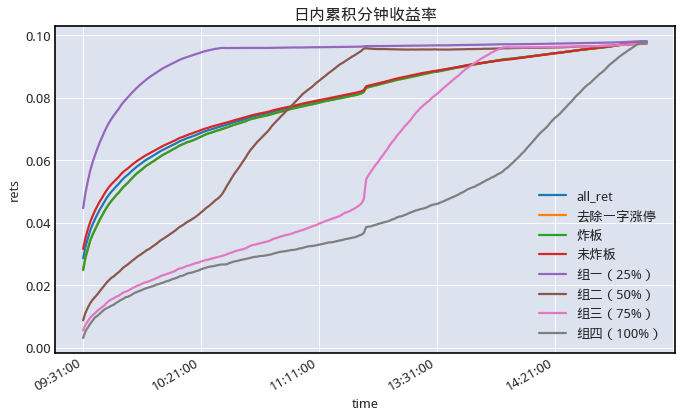

In [141]:
# 设置图形的尺寸和分辨率
plt.figure(figsize=(10, 6), dpi=80)
# 绘制折线图
ret_all_day.cumsum().plot()
out_always_up_ret_all_day.cumsum().plot()
break_ret_all_day.cumsum().plot()
out_break_ret_all_day.cumsum().plot()
time_group_1_ret_day.cumsum().plot()
time_group_2_ret_day.cumsum().plot()
time_group_3_ret_day.cumsum().plot()
time_group_4_ret_day.cumsum().plot()
# 添加标题和标签
plt.title('日内累积分钟收益率')
plt.xlabel('time')
plt.ylabel('rets')
# 添加网格线
plt.grid(True)
# 添加图例
plt.legend(['all_ret','去除一字涨停','炸板','未炸板','组一（25%）','组二（50%）','组三（75%）','组四（100%）'])
# 自动调整日期格式
plt.gcf().autofmt_xdate()
# 显示图形
plt.show()

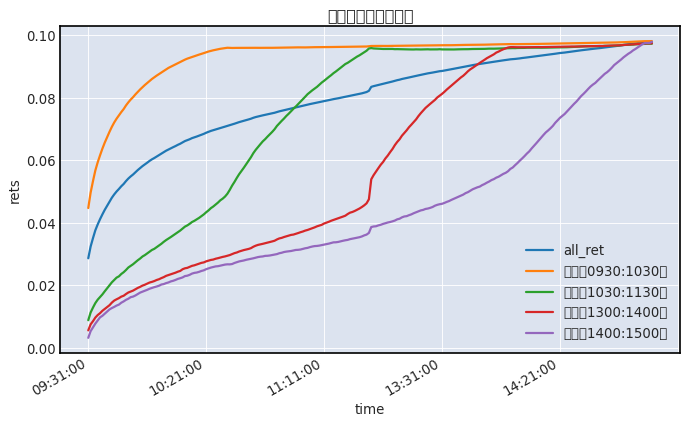

In [130]:
import matplotlib.pyplot as plt
# 设置图形的尺寸和分辨率
plt.figure(figsize=(10, 6), dpi=80)
# 绘制折线图
ret_all_day.cumsum().plot()
time_group_1_ret_day.cumsum().plot()
time_group_2_ret_day.cumsum().plot()
time_group_3_ret_day.cumsum().plot()
time_group_4_ret_day.cumsum().plot()
# 添加标题和标签
plt.title('日内累积分钟收益率')
plt.xlabel('time')
plt.ylabel('rets')
# 添加网格线
plt.grid(True)
# 添加图例
plt.legend(['all_ret','组一（0930:1030）','组二（1030:1130）','组三（1300:1400）','组四（1400:1500）'])
# 自动调整日期格式
plt.gcf().autofmt_xdate()
# 显示图形
plt.show()

# N日K线图

In [135]:
import mplfinance as mpf

def event_K_line(event,n,open_,close,high,low):
    event_close_pre=pd.DataFrame({'T'+str(i):(event*close.shift(-1*i+1,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    event_close=pd.DataFrame({'T'+str(i):(event*close.shift(-1*i,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    event_open=pd.DataFrame({'T'+str(i):(event*open_.shift(-1*i,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    event_high=pd.DataFrame({'T'+str(i):(event*high.shift(-1*i,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    event_low=pd.DataFrame({'T'+str(i):(event*low.shift(-1*i,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    
    w0=pd.DataFrame({'T'+str(i):event_close_pre.loc[:,'T0'] for i in range(n)})
    mean_event=pd.DataFrame({'open':(event_open/w0).mean(),'close':(event_close/w0).mean(),'high':(event_high/w0).mean(),'low':(event_low/w0).mean()})
    
    # mean_event.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105']) #便于利用mplfinance画图
    return mean_event,event_close,event_open,event_high,event_low

In [97]:
close = ff.read('close')*ff.filter0*ff.read('post')
open = ff.read('open')*ff.filter0*ff.read('post') 
high = ff.read('high')*ff.filter0*ff.read('post') 
low = ff.read('low')*ff.filter0*ff.read('post') 

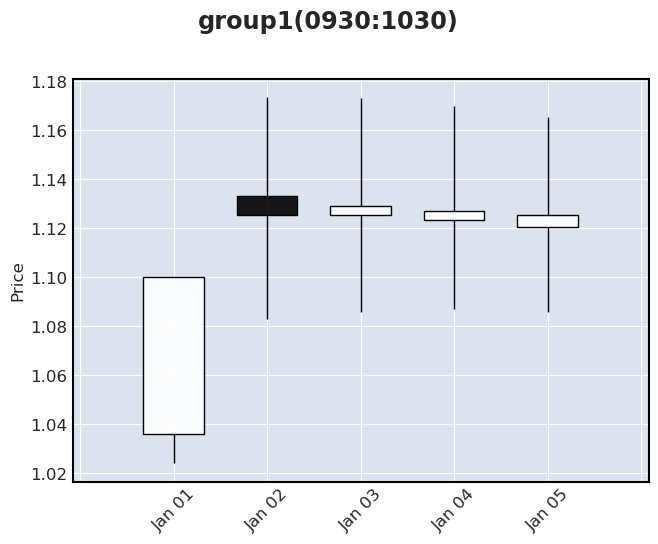

In [136]:
mean_event = event_K_line(group1_event.T,5,open,close,high,low)[0]

mean_event.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105'])
mpf.plot(mean_event,type='candle',style='default',title = 'group1(0930:1030)')

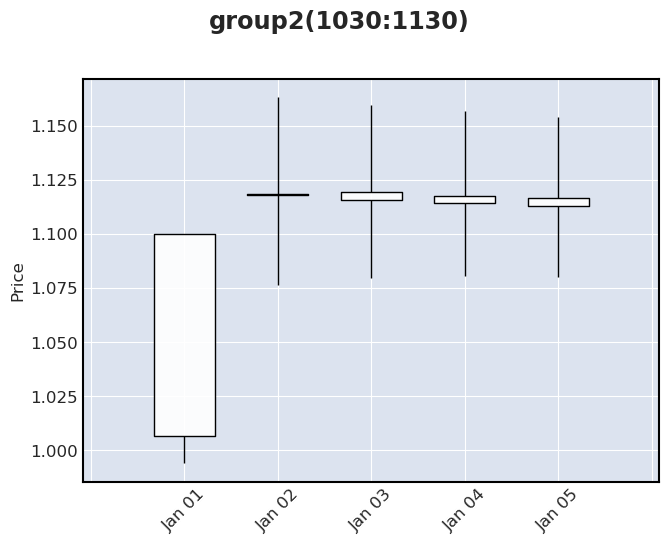

In [137]:
mean_event = event_K_line(group2_event.T,5,open,close,high,low)[0]

mean_event.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105'])
mpf.plot(mean_event,type='candle',style='default',title = 'group2(1030:1130)')

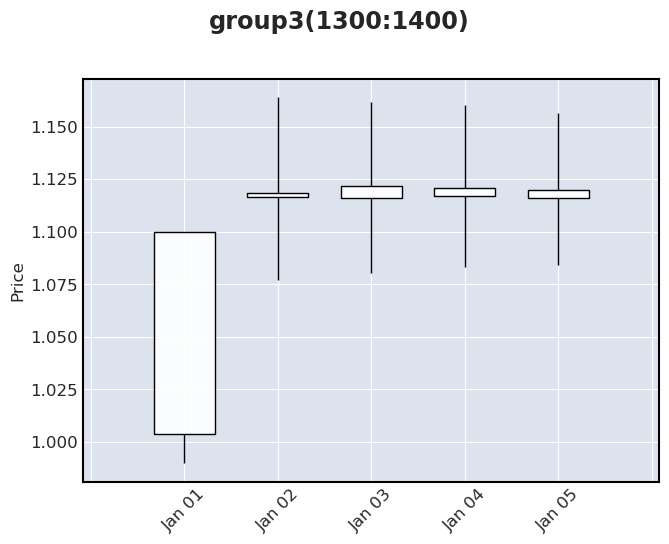

In [138]:
mean_event = event_K_line(group3_event.T,5,open,close,high,low)[0]

mean_event.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105'])
mpf.plot(mean_event,type='candle',style='default',title = 'group3(1300:1400)')

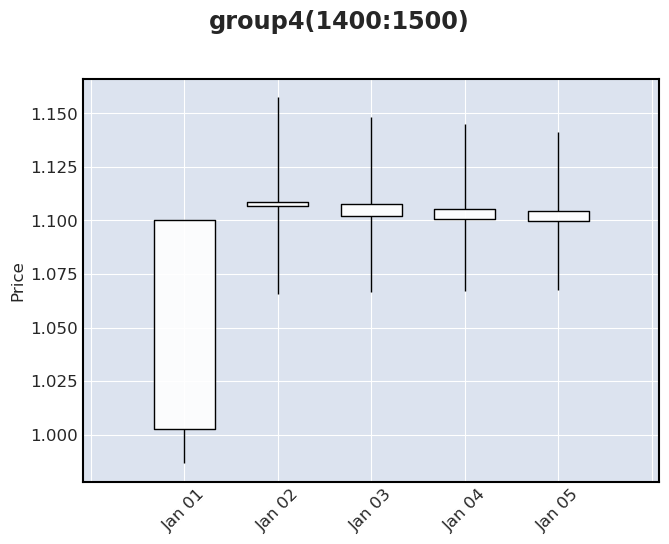

In [139]:
mean_event = event_K_line(group4_event.T,5,open,close,high,low)[0]

mean_event.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105'])
mpf.plot(mean_event,type='candle',style='default',title = 'group4(1400:1500)')

In [1]:
code = '000001.SZ'

In [6]:
up_data.loc[code,:].dropna()

20130114    1.0
20130128    1.0
20130305    1.0
20130711    1.0
20141128    1.0
20150410    1.0
20200706    1.0
20221129    1.0
20240221    1.0
Name: 000001.SZ, dtype: float64

In [12]:
ff.rets_all.loc[code,'20240221':]

20240221    0.099796
20240222    0.009259
20240223   -0.004587
20240226   -0.029493
20240227   -0.002849
20240228   -0.000952
20240229    0.009533
20240301   -0.009443
20240304   -0.015253
20240305    0.009681
20240306   -0.009588
20240307    0.004840
20240308    0.000000
20240311    0.008671
20240312    0.008596
20240313   -0.021780
20240314   -0.009681
20240315    0.036168
20240318   -0.005660
20240319   -0.013283
20240320    0.004808
20240321    0.001914
20240322   -0.010506
20240325    0.003861
20240326    0.019231
20240327   -0.006604
20240328   -0.003799
20240329    0.002860
20240401    0.011407
20240402   -0.008459
20240403   -0.008531
20240408   -0.002868
20240409   -0.002876
20240410   -0.011538
20240411   -0.002918
20240412   -0.018537
20240415    0.022863
20240416   -0.000972
Name: 000001.SZ, dtype: float64